## IBM Applied Data Science Capstone

### Final Report Notebook

Opening a New High-End Irish Pub in NYC

The goal of this report is to find the best neighborhoods in NYC for opening a high-end Irish Pub.

## Introduction/Business Problem

The city of Boston is well known for many of its citizens having Irish roots. With those roots comes many Irish pubs. The basis for this study is to help a group of investors in Boston expand their successful Pub chain to the New York City area. New York City offers a vast and diverse market that ranks among the most populous cities in the world. Due to the complexity and diversity in the city, the group of investors has asked for assistance in selecting the correct area to expand their restaurant to. 

They believe that an area must meet certain criteria for them to consider it:

- It must be considerably wealthy, because of the nature of the high-end restaurant. This will be measured through average income.

- It must have a high population of people that live near it

- It must not have too many restaurants that are similar already around their new location.

In the past these criteria have been great indicators on whether the restaurant has fared well or not. The investors believe that leveraging both population data as well as location data, will provide a strong base for a profitable expansion.


## Data

To solve the problem the following data sources will be used:

•	New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.

Source: https://cocl.us/new_york_dataset

•	GeoSpace Data

Source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

This data will help to get the boundaries for the Boroughs and neighborhoods for visualization

•	Venue data

Source: Foursquare API

This api will help us to get all the venues from each neighborhood

•	Census data

Source: https://www.kaggle.com/muonneutrino/new-york-city-census-data

This dataset contains demographic and economic data for NYC

•	NYC population data

Source: https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoodpop.htm

This data contains regions of New York and their subsequent populations


By leveraging these 5 datasets, we will be able to adequately answer all of the investor’s criteria marks for each neighborhood and cluster each based on their desirability for expanding the restaurant.


First we must import all necessary libraries

In [18]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


Here we are uploading the New York neighborhood and Borough data that includes longitude and latitude

In [19]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [20]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

<strong> Transforming the data into a pandas dataframe </strong>

In [21]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [22]:
neighborhoods_data = newyork_data['features']

In [23]:
# define the dataframe columns that we want
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [24]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Next let's loop through the data and fill the dataframe one row at a time.

In [25]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [187]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


We can also verify whether the dataframe has the correct number of boroughs and neighborhoods

In [27]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [29]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods on top

In [30]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Next we will utilize Foursqaure to identify venues in each neighborhood

In [31]:
#Defining foursquare credentials and version
CLIENT_ID = 'U2TOTVIKFF5X214V005PFHW0HWP3O5C5EVWNBEQVMJWJWU5W' # your Foursquare ID
CLIENT_SECRET = 'MHJTJGAD2XSYS5HWPCFV1OV2BINI3R3P3U1DDRDWWOWDIORK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: U2TOTVIKFF5X214V005PFHW0HWP3O5C5EVWNBEQVMJWJWU5W
CLIENT_SECRET:MHJTJGAD2XSYS5HWPCFV1OV2BINI3R3P3U1DDRDWWOWDIORK


This function will get the top 100 venues for all neighborhoods in NYC

In [34]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [36]:
print(newyork_venues.shape)
newyork_venues.head()

(9831, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Let's check how many venues were returned for each neighborhood

In [37]:
newyork_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,29,29,29,29,29,29
Annadale,10,10,10,10,10,10
Arden Heights,4,4,4,4,4,4
Arlington,8,8,8,8,8,8
Arrochar,22,22,22,22,22,22
Arverne,17,17,17,17,17,17
Astoria,96,96,96,96,96,96
Astoria Heights,13,13,13,13,13,13
Auburndale,16,16,16,16,16,16


Let's find out how many unique categories can be curated from all the returned venues

In [38]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))

There are 431 uniques categories.


##  Methodology

In this project we will first try to extract the best neighborhoods that have low densities of restaurants related to Irish Pubs. We can accomplish this by separating each neighborhood and the venues that are in it.

In the first step we have accomplished acquiring the required data. This includes the location and type of venue in each neighborhood in New York City.

The second part of our analysis will be calculation and exploration of 'restaurant density' across all areas of New York City. We will create a frequency of all venues in neighbrohoods ad cluster these based on their frequency of "Pub" related restraurants. We will also create a descending order table of neighborhoods' top venues and their cluster category along with their Pub related frequency.

In the third step we will eliminate all the neighborhoods in the clusters that contain higher densities of the Pub venues. Next the remaining neighborhoods will be analyzed using income range. Because of the available data it will be broken down by Borough. The highest income Borough will be selected and all others will be reomved. Lastly the populations of each region will be explored and the optimal neighborhood will be selected


## Analyze each Neighborhood

In [39]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we can group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [40]:
newyork_grouped = newyork_onehot.groupby(["Neighborhood"]).mean().reset_index()

print(newyork_grouped.shape)
newyork_grouped

(301, 431)


,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,...,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Allerton,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Annadale,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.100000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Arden Heights,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Arlington,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.125000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Arrochar,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Arverne,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000
6,Astoria,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.010417,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.020833,0.000000,0.000000
7,Astoria Heights,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Auburndale,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.062500,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Bath Beach,0.000000,0.000000,0.0,0.0000,0.00,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408


### Next we will create a new dataframe with any venues that relate to breweries
Based on the given venue names these 4 places have been selected: "Bar","Beer Bar","Beer Garden","Pub"

In [41]:
newyork_beer = newyork_grouped[["Neighborhood","Bar","Beer Bar","Beer Garden", "Pub"]]

### After this we will cluster neighborhoods based off this dataframe

In [42]:
#We want to eliminate a minimum of 4 clusters

kclusters = 10

newyork_clustering = newyork_beer.drop(["Neighborhood"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 3, 1, 5, 1], dtype=int32)

#### Let's print each neighborhood along with the top 5 most common venues

In [43]:
num_top_venues = 5

for hood in newyork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = newyork_grouped[newyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
           venue  freq
0    Pizza Place  0.14
1  Deli / Bodega  0.07
2  Grocery Store  0.07
3    Supermarket  0.07
4       Pharmacy  0.03


----Annadale----
           venue  freq
0       Pharmacy   0.1
1     Sports Bar   0.1
2   Liquor Store   0.1
3  Train Station   0.1
4          Diner   0.1


----Arden Heights----
           venue  freq
0       Pharmacy  0.25
1  Deli / Bodega  0.25
2    Pizza Place  0.25
3    Coffee Shop  0.25
4    Yoga Studio  0.00


----Arlington----
                 venue  freq
0         Liquor Store  0.12
1        Grocery Store  0.12
2        Deli / Bodega  0.12
3        Boat or Ferry  0.12
4  American Restaurant  0.12


----Arrochar----
                venue  freq
0  Italian Restaurant  0.09
1       Deli / Bodega  0.09
2            Bus Stop  0.09
3        Liquor Store  0.09
4               Hotel  0.05


----Arverne----
             venue  freq
0        Surf Spot  0.24
1    Metro Station  0.12
2   Sandwich Place  0.12
3       Playground  0.06
4 

                venue  freq
0  Italian Restaurant  0.11
1         Coffee Shop  0.07
2         Pizza Place  0.05
3              Bakery  0.04
4        Cocktail Bar  0.04


----Castle Hill----
            venue  freq
0     Pizza Place  0.25
1        Pharmacy  0.12
2           Diner  0.12
3          Market  0.12
4  Baseball Field  0.12


----Castleton Corners----
                 venue  freq
0          Pizza Place  0.19
1       Sandwich Place  0.06
2        Grocery Store  0.06
3         Burger Joint  0.06
4  Japanese Restaurant  0.06


----Central Harlem----
                 venue  freq
0   African Restaurant  0.07
1   Chinese Restaurant  0.07
2       Cosmetics Shop  0.04
3    French Restaurant  0.04
4  American Restaurant  0.04


----Charleston----
             venue  freq
0   Cosmetics Shop  0.07
1    Big Box Store  0.07
2      Coffee Shop  0.04
3     Burger Joint  0.04
4  Supplement Shop  0.04


----Chelsea----
                 venue  freq
0          Art Gallery  0.15
1          Coffee 

                 venue  freq
0             Bus Stop  0.25
1   Italian Restaurant  0.12
2  American Restaurant  0.12
3          Pizza Place  0.12
4       Ice Cream Shop  0.12


----Elmhurst----
                   venue  freq
0        Thai Restaurant  0.21
1     Mexican Restaurant  0.17
2     Chinese Restaurant  0.08
3  Vietnamese Restaurant  0.08
4                   Park  0.04


----Eltingville----
                  venue  freq
0           Pizza Place  0.12
1      Sushi Restaurant  0.10
2          Liquor Store  0.05
3  Fast Food Restaurant  0.05
4              Pharmacy  0.05


----Emerson Hill----
                        venue  freq
0  Construction & Landscaping   0.5
1            Sculpture Garden   0.5
2                 Yoga Studio   0.0
3       Outdoors & Recreation   0.0
4         Peruvian Restaurant   0.0


----Erasmus----
                  venue  freq
0  Caribbean Restaurant  0.14
1           Yoga Studio  0.05
2                  Bank  0.05
3                School  0.05
4     Conven

                  venue  freq
0    Italian Restaurant  0.08
1        Sandwich Place  0.05
2            Bagel Shop  0.05
3              Pharmacy  0.05
4  Fast Food Restaurant  0.05


----Hudson Yards----
                  venue  freq
0    Italian Restaurant  0.06
1  Gym / Fitness Center  0.06
2                  Café  0.06
3   American Restaurant  0.06
4                 Hotel  0.06


----Huguenot----
                venue  freq
0  Italian Restaurant  0.12
1      Ice Cream Shop  0.12
2                Bank  0.12
3       Train Station  0.12
4          Donut Shop  0.12


----Hunters Point----
                  venue  freq
0    Italian Restaurant  0.07
1                  Café  0.07
2   Japanese Restaurant  0.05
3        Scenic Lookout  0.04
4  Gym / Fitness Center  0.04


----Hunts Point----
            venue  freq
0  Shipping Store  0.08
1  Waste Facility  0.08
2   Grocery Store  0.08
3  Farmers Market  0.08
4       BBQ Joint  0.08


----Inwood----
                venue  freq
0  Mexican Rest

                  venue  freq
0             Locksmith   0.5
1                  Pool   0.5
2           Yoga Studio   0.0
3  Outdoor Supply Store   0.0
4    Persian Restaurant   0.0


----Morningside Heights----
                 venue  freq
0                 Park  0.10
1          Coffee Shop  0.07
2            Bookstore  0.07
3  American Restaurant  0.07
4        Deli / Bodega  0.05


----Morris Heights----
           venue  freq
0           Bank  0.12
1    Pizza Place  0.12
2       Pharmacy  0.12
3  Deli / Bodega  0.12
4           Park  0.12


----Morris Park----
           venue  freq
0    Pizza Place  0.18
1         Bakery  0.09
2  Deli / Bodega  0.09
3   Burger Joint  0.09
4            Bar  0.09


----Morrisania----
            venue  freq
0  Discount Store  0.11
1     Bus Station  0.11
2     Pizza Place  0.07
3      Donut Shop  0.07
4   Grocery Store  0.07


----Mott Haven----
                venue  freq
0                 Gym  0.11
1         Pizza Place  0.11
2          Donut Shop  

               venue  freq
0               Bank  0.13
1         Donut Shop  0.07
2           Bus Stop  0.07
3        Fish Market  0.07
4  Mobile Phone Shop  0.07


----Queensboro Hill----
                           venue  freq
0             Chinese Restaurant  0.17
1                           Bank  0.08
2                         Bakery  0.08
3                     Hobby Shop  0.04
4  Vegetarian / Vegan Restaurant  0.04


----Queensbridge----
                venue  freq
0               Hotel  0.20
1      Sandwich Place  0.13
2      Scenic Lookout  0.07
3  Athletics & Sports  0.07
4    Basketball Court  0.07


----Randall Manor----
           venue  freq
0           Park  0.29
1       Bus Stop  0.29
2     Bagel Shop  0.14
3  Deli / Bodega  0.14
4   Carpet Store  0.14


----Ravenswood----
                 venue  freq
0   Chinese Restaurant  0.10
1   Italian Restaurant  0.03
2  Fried Chicken Joint  0.03
3                  Bar  0.03
4        Grocery Store  0.03


----Red Hook----
           

                 venue  freq
0                  Bar  0.07
1        Grocery Store  0.05
2          Pizza Place  0.04
3    Korean Restaurant  0.03
4  American Restaurant  0.03


----Sunset Park----
                       venue  freq
0         Mexican Restaurant  0.08
1                Pizza Place  0.08
2  Latin American Restaurant  0.08
3                     Bakery  0.08
4                       Bank  0.08


----Sutton Place----
                  venue  freq
0    Italian Restaurant  0.05
1                  Park  0.05
2           Coffee Shop  0.04
3  Gym / Fitness Center  0.04
4                   Gym  0.03


----Throgs Neck----
                venue  freq
0       Deli / Bodega  0.18
1         Coffee Shop  0.18
2  Italian Restaurant  0.09
3                 Bar  0.09
4         Pizza Place  0.09


----Todt Hill----
                   venue  freq
0                   Park   1.0
1            Yoga Studio   0.0
2               Pet Café   0.0
3     Persian Restaurant   0.0
4  Performing Arts Venue  

Now let's write a function to sort the venues in descending order.

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Next let's create the new dataframe and display the top 10 venues for each neighborhood.

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Supermarket,Grocery Store,Deli / Bodega,Dessert Shop,Gas Station,Donut Shop,Fried Chicken Joint,Pharmacy,Fast Food Restaurant
1,Annadale,Food,Diner,Sports Bar,Train Station,Liquor Store,American Restaurant,Dance Studio,Pizza Place,Pharmacy,Restaurant
2,Arden Heights,Pizza Place,Pharmacy,Deli / Bodega,Coffee Shop,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
3,Arlington,Deli / Bodega,Tree,Grocery Store,Liquor Store,American Restaurant,Coffee Shop,Bus Stop,Boat or Ferry,Exhibit,Factory
4,Arrochar,Bus Stop,Liquor Store,Italian Restaurant,Deli / Bodega,Athletics & Sports,Mediterranean Restaurant,Sporting Goods Shop,Bagel Shop,Middle Eastern Restaurant,Sandwich Place


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [46]:
merge = neighborhoods_venues_sorted

In [47]:
merge["Cluster Labels"] = kmeans.labels_

In [48]:
merge.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
merge.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Allerton,Pizza Place,Supermarket,Grocery Store,Deli / Bodega,Dessert Shop,Gas Station,Donut Shop,Fried Chicken Joint,Pharmacy,Fast Food Restaurant,1
1,Annadale,Food,Diner,Sports Bar,Train Station,Liquor Store,American Restaurant,Dance Studio,Pizza Place,Pharmacy,Restaurant,1
2,Arden Heights,Pizza Place,Pharmacy,Deli / Bodega,Coffee Shop,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,1
3,Arlington,Deli / Bodega,Tree,Grocery Store,Liquor Store,American Restaurant,Coffee Shop,Bus Stop,Boat or Ferry,Exhibit,Factory,1
4,Arrochar,Bus Stop,Liquor Store,Italian Restaurant,Deli / Bodega,Athletics & Sports,Mediterranean Restaurant,Sporting Goods Shop,Bagel Shop,Middle Eastern Restaurant,Sandwich Place,1


In [49]:
merge = merge.join(neighborhoods.set_index("Neighborhood"), on="Neighborhood")

print(merge.shape)
merge.head() # check the last columns!

(305, 15)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
0,Allerton,Pizza Place,Supermarket,Grocery Store,Deli / Bodega,Dessert Shop,Gas Station,Donut Shop,Fried Chicken Joint,Pharmacy,Fast Food Restaurant,1,Bronx,40.865788,-73.859319
1,Annadale,Food,Diner,Sports Bar,Train Station,Liquor Store,American Restaurant,Dance Studio,Pizza Place,Pharmacy,Restaurant,1,Staten Island,40.538114,-74.178549
2,Arden Heights,Pizza Place,Pharmacy,Deli / Bodega,Coffee Shop,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,1,Staten Island,40.549286,-74.185887
3,Arlington,Deli / Bodega,Tree,Grocery Store,Liquor Store,American Restaurant,Coffee Shop,Bus Stop,Boat or Ferry,Exhibit,Factory,1,Staten Island,40.635325,-74.165104
4,Arrochar,Bus Stop,Liquor Store,Italian Restaurant,Deli / Bodega,Athletics & Sports,Mediterranean Restaurant,Sporting Goods Shop,Bagel Shop,Middle Eastern Restaurant,Sandwich Place,1,Staten Island,40.596313,-74.067124


## Now lets visualize the data

In [50]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merge['Latitude'], merge['Longitude'], merge['Neighborhood'], merge['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can sort the clusters in ascedning order and compare them against the frequency of beer related restaurants

In [51]:
newyork_beer

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub
0,Allerton,0.000000,0.00,0.000000,0.000000
1,Annadale,0.000000,0.00,0.000000,0.000000
2,Arden Heights,0.000000,0.00,0.000000,0.000000
3,Arlington,0.000000,0.00,0.000000,0.000000
4,Arrochar,0.000000,0.00,0.000000,0.000000
5,Arverne,0.000000,0.00,0.000000,0.000000
6,Astoria,0.062500,0.00,0.010417,0.020833
7,Astoria Heights,0.000000,0.00,0.000000,0.000000
8,Auburndale,0.062500,0.00,0.000000,0.000000
9,Bath Beach,0.000000,0.00,0.000000,0.000000


In [52]:
cluster_beer = newyork_beer.copy()

In [53]:
cluster_beer["Cluster Labels"] = kmeans.labels_

In [54]:
cluster_beer.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
cluster_beer.head()

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
0,Allerton,0.0,0.0,0.0,0.0,1
1,Annadale,0.0,0.0,0.0,0.0,1
2,Arden Heights,0.0,0.0,0.0,0.0,1
3,Arlington,0.0,0.0,0.0,0.0,1
4,Arrochar,0.0,0.0,0.0,0.0,1


In [55]:
cluster_beer.sort_values(["Cluster Labels"], inplace=True)
pd.set_option('display.max_columns', None)
cluster_beer

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
17,Bedford Stuyvesant,0.076923,0.000000,0.000000,0.000000,0
39,Bushwick,0.095890,0.000000,0.000000,0.000000,0
254,South Side,0.090000,0.000000,0.010000,0.010000,0
180,Morris Park,0.090909,0.000000,0.000000,0.000000,0
267,Throgs Neck,0.090909,0.000000,0.000000,0.000000,0
82,East Williamsburg,0.101449,0.000000,0.000000,0.000000,0
110,Gerritsen Beach,0.117647,0.000000,0.000000,0.000000,0
285,West Brighton,0.075000,0.000000,0.000000,0.000000,0
246,Shore Acres,0.083333,0.000000,0.000000,0.000000,0
212,Pomonok,0.111111,0.000000,0.000000,0.000000,0


## Cluster 0

In [56]:
merge.loc[merge['Cluster Labels'] == 0, merge.columns[[0] + list(range(1, merge.shape[1]))]]


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
17,Bedford Stuyvesant,Café,Bar,Pizza Place,Coffee Shop,Fried Chicken Joint,Discount Store,New American Restaurant,Boutique,Gift Shop,Gourmet Shop,0,Brooklyn,40.687232,-73.941785
39,Bushwick,Bar,Mexican Restaurant,Deli / Bodega,Coffee Shop,Pizza Place,Bakery,Discount Store,Thrift / Vintage Store,Vegetarian / Vegan Restaurant,Chinese Restaurant,0,Brooklyn,40.698116,-73.925258
82,East Williamsburg,Bar,Deli / Bodega,Cocktail Bar,Coffee Shop,Bakery,Music Venue,Concert Hall,Vegetarian / Vegan Restaurant,Café,Mexican Restaurant,0,Brooklyn,40.708492,-73.938858
110,Gerritsen Beach,Bar,Convenience Store,Restaurant,Café,Gas Station,Event Space,Martial Arts Dojo,Baseball Field,Bagel Shop,Seafood Restaurant,0,Brooklyn,40.590848,-73.930102
120,Greenpoint,Bar,Pizza Place,Coffee Shop,Cocktail Bar,Yoga Studio,Grocery Store,Deli / Bodega,Arts & Crafts Store,Sushi Restaurant,Café,0,Brooklyn,40.730201,-73.954241
180,Morris Park,Pizza Place,Burger Joint,Deli / Bodega,Bar,Bakery,Bank,Donut Shop,Pharmacy,Sandwich Place,Supermarket,0,Bronx,40.847549,-73.850402
212,Pomonok,Bar,Pizza Place,Shop & Service,Halal Restaurant,Japanese Restaurant,Bowling Alley,Supermarket,Scenic Lookout,Playground,Event Space,0,Queens,40.734936,-73.804861
217,Prospect Heights,Bar,Mexican Restaurant,Café,Cocktail Bar,Thai Restaurant,American Restaurant,Gourmet Shop,Coffee Shop,Beer Bar,Bakery,0,Brooklyn,40.676822,-73.964859
246,Shore Acres,Italian Restaurant,Deli / Bodega,Bus Stop,Intersection,Bar,Bagel Shop,Gastropub,Furniture / Home Store,Music Store,Nail Salon,0,Staten Island,40.609719,-74.066678
254,South Side,Bar,Coffee Shop,American Restaurant,Pizza Place,Yoga Studio,Wine Bar,Breakfast Spot,South American Restaurant,Japanese Restaurant,Bakery,0,Brooklyn,40.710861,-73.958001


In [57]:
cluster_beer[cluster_beer['Cluster Labels'] == 0]

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
17,Bedford Stuyvesant,0.076923,0.000000,0.00,0.00,0
39,Bushwick,0.095890,0.000000,0.00,0.00,0
254,South Side,0.090000,0.000000,0.01,0.01,0
180,Morris Park,0.090909,0.000000,0.00,0.00,0
267,Throgs Neck,0.090909,0.000000,0.00,0.00,0
82,East Williamsburg,0.101449,0.000000,0.00,0.00,0
110,Gerritsen Beach,0.117647,0.000000,0.00,0.00,0
285,West Brighton,0.075000,0.000000,0.00,0.00,0
246,Shore Acres,0.083333,0.000000,0.00,0.00,0
212,Pomonok,0.111111,0.000000,0.00,0.00,0


Cluster 0 has a high density of Irish Pub related restaurants so these neighborhoods will be eliminated.

## Cluster 1

In [58]:
merge.loc[merge['Cluster Labels'] == 1, merge.columns[[0] + list(range(1, merge.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
0,Allerton,Pizza Place,Supermarket,Grocery Store,Deli / Bodega,Dessert Shop,Gas Station,Donut Shop,Fried Chicken Joint,Pharmacy,Fast Food Restaurant,1,Bronx,40.865788,-73.859319
1,Annadale,Food,Diner,Sports Bar,Train Station,Liquor Store,American Restaurant,Dance Studio,Pizza Place,Pharmacy,Restaurant,1,Staten Island,40.538114,-74.178549
2,Arden Heights,Pizza Place,Pharmacy,Deli / Bodega,Coffee Shop,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,1,Staten Island,40.549286,-74.185887
3,Arlington,Deli / Bodega,Tree,Grocery Store,Liquor Store,American Restaurant,Coffee Shop,Bus Stop,Boat or Ferry,Exhibit,Factory,1,Staten Island,40.635325,-74.165104
4,Arrochar,Bus Stop,Liquor Store,Italian Restaurant,Deli / Bodega,Athletics & Sports,Mediterranean Restaurant,Sporting Goods Shop,Bagel Shop,Middle Eastern Restaurant,Sandwich Place,1,Staten Island,40.596313,-74.067124
5,Arverne,Surf Spot,Metro Station,Sandwich Place,Donut Shop,Board Shop,Wine Shop,Coffee Shop,Thai Restaurant,Beach,Bus Stop,1,Queens,40.589144,-73.791992
7,Astoria Heights,Bakery,Plaza,Liquor Store,Bus Station,Supermarket,Pizza Place,Bowling Alley,Playground,Hostel,Deli / Bodega,1,Queens,40.770317,-73.894680
9,Bath Beach,Pizza Place,Pharmacy,Italian Restaurant,Gas Station,Sushi Restaurant,Bubble Tea Shop,Fast Food Restaurant,Chinese Restaurant,Park,Burger Joint,1,Brooklyn,40.599519,-73.998752
12,Bay Terrace,Clothing Store,Italian Restaurant,Donut Shop,Supermarket,Lingerie Store,Kids Store,Mobile Phone Shop,Shoe Store,Women's Store,American Restaurant,1,Queens,40.782843,-73.776802
12,Bay Terrace,Clothing Store,Italian Restaurant,Donut Shop,Supermarket,Lingerie Store,Kids Store,Mobile Phone Shop,Shoe Store,Women's Store,American Restaurant,1,Staten Island,40.553988,-74.139166


In [59]:
cluster_beer[cluster_beer['Cluster Labels'] == 1]

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
199,Ocean Hill,0.00,0.00,0.000000,0.0,1
175,Midwood,0.00,0.00,0.000000,0.0,1
203,Ozone Park,0.00,0.00,0.000000,0.0,1
177,Mill Island,0.00,0.00,0.000000,0.0,1
202,Olinville,0.00,0.00,0.000000,0.0,1
179,Morris Heights,0.00,0.00,0.000000,0.0,1
181,Morrisania,0.00,0.00,0.000000,0.0,1
182,Mott Haven,0.00,0.00,0.000000,0.0,1
184,Mount Hope,0.00,0.00,0.000000,0.0,1
187,New Brighton,0.00,0.00,0.000000,0.0,1


Cluster 1 does not have a high frequency of any of the 4 places, so these neighborhoods will stay

## Cluster 2

In [60]:
merge.loc[merge['Cluster Labels'] == 2, merge.columns[[0] + list(range(1, merge.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
213,Port Ivory,Bar,Women's Store,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,2,Staten Island,40.639683,-74.174645


In [137]:
cluster_beer[cluster_beer['Cluster Labels'] == 2]

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
25,Blissville,0.052632,0.000000,0.00,0.000000,2
292,Williamsburg,0.058824,0.000000,0.00,0.000000,2
237,Rosebank,0.034483,0.000000,0.00,0.000000,2
211,Pleasant Plains,0.055556,0.000000,0.00,0.000000,2
225,Red Hook,0.061224,0.000000,0.00,0.020408,2
235,Rockaway Park,0.037037,0.000000,0.00,0.000000,2
285,West Brighton,0.054054,0.000000,0.00,0.000000,2
281,Vinegar Hill,0.035714,0.000000,0.00,0.000000,2
221,Queensboro Hill,0.045455,0.000000,0.00,0.000000,2
243,Schuylerville,0.047619,0.000000,0.00,0.000000,2


Cluster 2 has a noteworthy number of bars, thus it will be eliminated.

## Cluster 3

In [61]:
merge.loc[merge['Cluster Labels'] == 3, merge.columns[[0] + list(range(1, merge.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
6,Astoria,Bar,Middle Eastern Restaurant,Greek Restaurant,Deli / Bodega,Bakery,Mediterranean Restaurant,Seafood Restaurant,Hookah Bar,Indian Restaurant,Italian Restaurant,3,Queens,40.768509,-73.915654
14,Bayside,Bar,Pub,Indian Restaurant,American Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Ice Cream Shop,Bakery,Donut Shop,3,Queens,40.766041,-73.774274
16,Bedford Park,Chinese Restaurant,Diner,Deli / Bodega,Mexican Restaurant,Pizza Place,Spanish Restaurant,Sandwich Place,Bus Station,Supermarket,Gym,3,Bronx,40.870185,-73.885512
43,Carnegie Hill,Coffee Shop,Yoga Studio,Wine Shop,Bookstore,Pizza Place,Japanese Restaurant,Gym,Café,Grocery Store,Bar,3,Manhattan,40.782683,-73.953256
86,Edgewater Park,Italian Restaurant,Deli / Bodega,Coffee Shop,Pizza Place,Donut Shop,Liquor Store,Asian Restaurant,Sports Bar,Bar,Spa,3,Bronx,40.821986,-73.813885
114,Gramercy,Italian Restaurant,Bagel Shop,Coffee Shop,Playground,Bar,Grocery Store,Mexican Restaurant,Pizza Place,Park,Spa,3,Manhattan,40.737210,-73.981376
144,Kew Gardens,Chinese Restaurant,Bar,Spa,Pet Store,Bank,Deli / Bodega,Park,Cosmetics Shop,Pizza Place,Indian Restaurant,3,Queens,40.705179,-73.829819
146,Kingsbridge,Pizza Place,Bar,Mexican Restaurant,Sandwich Place,Supermarket,Latin American Restaurant,Spanish Restaurant,Deli / Bodega,Fried Chicken Joint,Bakery,3,Bronx,40.881687,-73.902818
225,Red Hook,Seafood Restaurant,American Restaurant,Park,Bar,Art Gallery,Farm,New American Restaurant,Pizza Place,Flower Shop,Ice Cream Shop,3,Brooklyn,40.676253,-74.012759
264,Sunnyside Gardens,Bar,Grocery Store,Pizza Place,Pharmacy,Supermarket,Thai Restaurant,American Restaurant,Coffee Shop,Turkish Restaurant,Korean Restaurant,3,Queens,40.745652,-73.918193


In [62]:
cluster_beer[cluster_beer['Cluster Labels'] == 3]

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
225,Red Hook,0.062500,0.000000,0.000000,0.020833,3
43,Carnegie Hill,0.036145,0.000000,0.000000,0.024096,3
14,Bayside,0.069444,0.000000,0.013889,0.041667,3
16,Bedford Park,0.025641,0.000000,0.000000,0.025641,3
264,Sunnyside Gardens,0.070000,0.000000,0.000000,0.020000,3
6,Astoria,0.062500,0.000000,0.010417,0.020833,3
288,Westchester Square,0.031250,0.000000,0.000000,0.031250,3
300,Yorkville,0.040000,0.000000,0.000000,0.020000,3
144,Kew Gardens,0.044444,0.000000,0.000000,0.022222,3
114,Gramercy,0.041667,0.013889,0.000000,0.013889,3


Cluster 3 has an average frequency of bars and pubs, but since it contains both it will be eliminated from contention

## Cluster 4

In [63]:
merge.loc[merge['Cluster Labels'] == 4, merge.columns[[0] + list(range(1, merge.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
106,Fox Hills,Bar,Deli / Bodega,Bus Station,Bus Stop,Sandwich Place,Women's Store,Farm,Entertainment Service,Ethiopian Restaurant,Event Service,4,Staten Island,40.617311,-74.081740
119,Great Kills,Bar,Pizza Place,Italian Restaurant,Cosmetics Shop,Food & Drink Shop,Spanish Restaurant,Falafel Restaurant,Grocery Store,Sandwich Place,Pharmacy,4,Staten Island,40.549480,-74.149324
186,Neponsit,Beach,Bar,Women's Store,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,4,Queens,40.572037,-73.857547
253,South Ozone Park,Park,Bar,Deli / Bodega,Fast Food Restaurant,Donut Shop,Sandwich Place,Hotel,Food Truck,Filipino Restaurant,Flea Market,4,Queens,40.668550,-73.809865
291,Williamsbridge,Caribbean Restaurant,Soup Place,Convenience Store,Nightclub,Bar,Women's Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,4,Bronx,40.881039,-73.857446


In [64]:
cluster_beer[cluster_beer['Cluster Labels'] == 4]

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
253,South Ozone Park,0.153846,0.0,0.0,0.0,4
291,Williamsbridge,0.166667,0.0,0.0,0.0,4
186,Neponsit,0.200000,0.0,0.0,0.0,4
106,Fox Hills,0.200000,0.0,0.0,0.0,4
119,Great Kills,0.166667,0.0,0.0,0.0,4


Cluster 4 has bars at a very high frequency, so it will be eliminated.

## Cluster 5

In [65]:
merge.loc[merge['Cluster Labels'] == 5, merge.columns[[0] + list(range(1, merge.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
8,Auburndale,Gymnastics Gym,Hookah Bar,Bar,Pet Store,Pharmacy,Toy / Game Store,Miscellaneous Shop,Mobile Phone Shop,Korean Restaurant,Discount Store,5,Queens,40.761730,-73.791762
11,Bay Ridge,Spa,Pizza Place,Italian Restaurant,Bar,Thai Restaurant,Greek Restaurant,American Restaurant,Grocery Store,Ice Cream Shop,Bagel Shop,5,Brooklyn,40.625801,-74.030621
25,Blissville,Bus Station,Donut Shop,Deli / Bodega,Intersection,Bar,Skating Rink,Clothing Store,Cafeteria,Restaurant,Art Gallery,5,Queens,40.737251,-73.932442
27,Boerum Hill,Coffee Shop,Dance Studio,Bar,Furniture / Home Store,Spa,Bakery,French Restaurant,Sandwich Place,Arts & Crafts Store,Yoga Studio,5,Brooklyn,40.685683,-73.983748
46,Castleton Corners,Pizza Place,Bank,Deli / Bodega,Mini Golf,Tattoo Parlor,Grocery Store,Bar,Bagel Shop,Hardware Store,Sandwich Place,5,Staten Island,40.613336,-74.119181
47,Central Harlem,Chinese Restaurant,African Restaurant,Seafood Restaurant,French Restaurant,Cosmetics Shop,American Restaurant,Bar,Spa,Salon / Barbershop,Library,5,Manhattan,40.815976,-73.943211
51,City Island,Harbor / Marina,Seafood Restaurant,Thrift / Vintage Store,Bank,Diner,French Restaurant,Café,Smoke Shop,Boat or Ferry,Park,5,Bronx,40.847247,-73.786488
60,Cobble Hill,Playground,Bar,Coffee Shop,Pizza Place,Yoga Studio,Cocktail Bar,Ice Cream Shop,Italian Restaurant,French Restaurant,Mediterranean Restaurant,5,Brooklyn,40.687920,-73.998561
71,Dongan Hills,Italian Restaurant,Pizza Place,Pharmacy,Bagel Shop,Smoke Shop,Basketball Court,Chinese Restaurant,Tanning Salon,Bar,Flower Shop,5,Staten Island,40.588673,-74.096399
89,Elmhurst,Thai Restaurant,Mexican Restaurant,Chinese Restaurant,Vietnamese Restaurant,Park,Colombian Restaurant,Bar,Salon / Barbershop,Sushi Restaurant,Malay Restaurant,5,Queens,40.744049,-73.881656


In [66]:
cluster_beer[cluster_beer['Cluster Labels'] == 5]

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
224,Ravenswood,0.034483,0.000000,0.00,0.0,5
243,Schuylerville,0.055556,0.000000,0.00,0.0,5
147,Kingsbridge Heights,0.037037,0.000000,0.00,0.0,5
8,Auburndale,0.062500,0.000000,0.00,0.0,5
116,Grant City,0.050000,0.000000,0.00,0.0,5
98,Flatlands,0.045455,0.000000,0.00,0.0,5
281,Vinegar Hill,0.034483,0.000000,0.00,0.0,5
163,Manhattan Valley,0.048780,0.000000,0.00,0.0,5
11,Bay Ridge,0.035294,0.000000,0.00,0.0,5
262,Stuyvesant Town,0.052632,0.000000,0.00,0.0,5


Cluster 5 has bars at a higher frequency than multiple clusters, so it will be eliminated.

## Cluster 6

In [67]:
merge.loc[merge['Cluster Labels'] == 6, merge.columns[[0] + list(range(1, merge.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
198,Oakwood,Bar,Lawyer,Bus Stop,Women's Store,Farm,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,6,Staten Island,40.558462,-74.121566


In [68]:
cluster_beer[cluster_beer['Cluster Labels'] == 6]

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
198,Oakwood,0.333333,0.0,0.0,0.0,6


Oakwood has a high number of bars, so it will be eliminated.

## Cluster 7

In [69]:
merge.loc[merge['Cluster Labels'] == 7, merge.columns[[0] + list(range(1, merge.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
20,Belle Harbor,Beach,Pub,Spa,Deli / Bodega,Donut Shop,Boutique,Mexican Restaurant,Bagel Shop,Chinese Restaurant,Pharmacy,7,Queens,40.576156,-73.854018
297,Woodlawn,Pizza Place,Pub,Playground,Deli / Bodega,Food Truck,Train Station,Convenience Store,Rental Car Location,Pharmacy,Donut Shop,7,Bronx,40.898273,-73.867315


In [70]:
cluster_beer[cluster_beer['Cluster Labels'] == 7]

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
20,Belle Harbor,0.00,0.0,0.0,0.117647,7
297,Woodlawn,0.04,0.0,0.0,0.080000,7


Cluster 7 has an above average frequency of pubs, so it will be eliminated.

## Cluster 8

In [71]:
merge.loc[merge['Cluster Labels'] == 8, merge.columns[[0] + list(range(1, merge.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
10,Battery Park City,Park,Hotel,Gym,Coffee Shop,Memorial Site,Food Court,Plaza,Shopping Mall,Mexican Restaurant,Boat or Ferry,8,Manhattan,40.711932,-74.016869
21,Bellerose,Italian Restaurant,Pizza Place,Bank,Diner,Pub,Fast Food Restaurant,Motel,Mobile Phone Shop,Gas Station,Grocery Store,8,Queens,40.728573,-73.720128
65,Coney Island,Pizza Place,Baseball Stadium,Caribbean Restaurant,Brewery,Food Court,Skating Rink,Beach,Beer Garden,Pharmacy,Theme Park Ride / Attraction,8,Brooklyn,40.574293,-73.988683
105,Fort Hamilton,Sandwich Place,Pharmacy,Chinese Restaurant,Deli / Bodega,Pizza Place,Donut Shop,Italian Restaurant,Steakhouse,Cocktail Bar,Bank,8,Brooklyn,40.614768,-74.031979
109,Georgetown,Bank,Donut Shop,Pharmacy,Burger Joint,Discount Store,Miscellaneous Shop,Coffee Shop,Supermarket,Supplement Shop,Bagel Shop,8,Brooklyn,40.623845,-73.916075
143,Kensington,Thai Restaurant,Grocery Store,Ice Cream Shop,Pizza Place,Gas Station,Donut Shop,Bagel Shop,Bakery,Park,Lingerie Store,8,Brooklyn,40.642382,-73.980421
169,Maspeth,Bank,Pizza Place,Diner,Grocery Store,Mobile Phone Shop,Chinese Restaurant,Flower Shop,Lounge,Gourmet Shop,Taco Place,8,Queens,40.725427,-73.896217
176,Mill Basin,Pizza Place,Japanese Restaurant,Bank,Sushi Restaurant,Chinese Restaurant,Bagel Shop,Ice Cream Shop,Food,Liquor Store,Grocery Store,8,Brooklyn,40.615974,-73.915154
178,Morningside Heights,Park,Bookstore,American Restaurant,Coffee Shop,Café,Sandwich Place,Pizza Place,Deli / Bodega,Burger Joint,Tennis Court,8,Manhattan,40.808000,-73.963896
206,Park Slope,Coffee Shop,Burger Joint,Bookstore,American Restaurant,Pet Store,Pizza Place,Bakery,Bagel Shop,Thai Restaurant,Italian Restaurant,8,Brooklyn,40.672321,-73.977050


In [72]:
cluster_beer[cluster_beer['Cluster Labels'] == 8]

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
143,Kensington,0.000000,0.000000,0.000000,0.027778,8
21,Bellerose,0.000000,0.000000,0.000000,0.045455,8
269,Tompkinsville,0.000000,0.000000,0.000000,0.038462,8
109,Georgetown,0.000000,0.000000,0.000000,0.033333,8
266,Sutton Place,0.010526,0.021053,0.021053,0.010526,8
65,Coney Island,0.000000,0.000000,0.062500,0.000000,8
10,Battery Park City,0.000000,0.000000,0.033898,0.016949,8
169,Maspeth,0.000000,0.000000,0.000000,0.030303,8
178,Morningside Heights,0.000000,0.000000,0.000000,0.023810,8
206,Park Slope,0.000000,0.000000,0.000000,0.017544,8


Cluster 8 has below average frequency of everything, so it will stay.

## Cluster 9

In [73]:
merge.loc[merge['Cluster Labels'] == 9, merge.columns[[0] + list(range(1, merge.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Borough,Latitude,Longitude
22,Belmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Grocery Store,Dessert Shop,Bank,Mexican Restaurant,Donut Shop,Shoe Store,9,Bronx,40.857277,-73.888452
35,Brooklyn Heights,Yoga Studio,Deli / Bodega,Park,Bakery,Pharmacy,Italian Restaurant,Pizza Place,Gym,Mexican Restaurant,Bar,9,Brooklyn,40.695864,-73.993782
44,Carroll Gardens,Italian Restaurant,Coffee Shop,Pizza Place,Bakery,Cocktail Bar,Spa,Wine Shop,Bar,Gourmet Shop,Grocery Store,9,Brooklyn,40.680540,-73.994654
50,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Optical Shop,American Restaurant,Salon / Barbershop,Vietnamese Restaurant,Bar,Coffee Shop,Spa,9,Manhattan,40.715618,-73.994279
57,Clinton,Theater,Coffee Shop,Gym / Fitness Center,Gym,Hotel,Wine Shop,Pizza Place,American Restaurant,Sandwich Place,Italian Restaurant,9,Manhattan,40.759101,-73.996119
58,Clinton Hill,Pizza Place,Italian Restaurant,Wine Shop,Thai Restaurant,Mexican Restaurant,Yoga Studio,Indian Restaurant,Deli / Bodega,Grocery Store,Restaurant,9,Brooklyn,40.693229,-73.967843
70,Ditmas Park,Caribbean Restaurant,Deli / Bodega,Women's Store,Discount Store,Pizza Place,Chinese Restaurant,Donut Shop,Health Food Store,Japanese Restaurant,Kids Store,9,Brooklyn,40.643675,-73.961013
73,Downtown,Burger Joint,Pizza Place,Coffee Shop,Sandwich Place,Chinese Restaurant,Bar,Bank,Middle Eastern Restaurant,Juice Bar,Arts & Crafts Store,9,Brooklyn,40.690844,-73.983463
81,East Village,Pizza Place,Cocktail Bar,Wine Bar,Coffee Shop,Juice Bar,Japanese Restaurant,Mexican Restaurant,Ramen Restaurant,Vietnamese Restaurant,Ice Cream Shop,9,Manhattan,40.727847,-73.982226
90,Eltingville,Pizza Place,Sushi Restaurant,Fast Food Restaurant,Sandwich Place,Liquor Store,Pharmacy,Bank,Breakfast Spot,Gourmet Shop,Gym,9,Staten Island,40.542231,-74.164331


In [74]:
cluster_beer[cluster_beer['Cluster Labels'] == 9]

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
139,Jackson Heights,0.012195,0.000000,0.000000,0.000000,9
138,Inwood,0.017544,0.000000,0.000000,0.000000,9
136,Hunters Point,0.017544,0.000000,0.017544,0.000000,9
134,Hudson Yards,0.019608,0.000000,0.000000,0.019608,9
133,Howard Beach,0.026316,0.000000,0.000000,0.000000,9
132,Homecrest,0.027027,0.000000,0.000000,0.000000,9
278,Upper West Side,0.028571,0.000000,0.000000,0.014286,9
277,Upper East Side,0.012048,0.000000,0.000000,0.000000,9
155,Little Neck,0.018868,0.000000,0.000000,0.000000,9
273,Tudor City,0.014085,0.000000,0.000000,0.000000,9


Cluster 9 will stay because the bars are not too high a frequency.

# Based on these clusters we can eliminate a few areas that already are saturated with similar restaurants to Irish pubs.

### These include clusters 0, 2, 3, 4, 5, 6, and 7 

In [75]:
new_df = cluster_beer.copy()
new_df.head()

,Neighborhood,Bar,Beer Bar,Beer Garden,Pub,Cluster Labels
17,Bedford Stuyvesant,0.076923,0.0,0.00,0.00,0
39,Bushwick,0.095890,0.0,0.00,0.00,0
254,South Side,0.090000,0.0,0.01,0.01,0
180,Morris Park,0.090909,0.0,0.00,0.00,0
267,Throgs Neck,0.090909,0.0,0.00,0.00,0


We will first drop all frequency columns, so our dataframe can only be neighborhood names and cluster labels.

In [76]:
new_df.drop(['Bar', 'Beer Bar', 'Beer Garden', 'Pub'], axis=1, inplace= True)


In [77]:
new_df.head()

,Neighborhood,Cluster Labels
17,Bedford Stuyvesant,0
39,Bushwick,0
254,South Side,0
180,Morris Park,0
267,Throgs Neck,0


Next we will add latitue and longitude, so that we still know the coordinates to map out each location

In [78]:
new_df = new_df.join(neighborhoods.set_index("Neighborhood"), on="Neighborhood")

In [79]:
new_df

,Neighborhood,Cluster Labels,Borough,Latitude,Longitude
17,Bedford Stuyvesant,0,Brooklyn,40.687232,-73.941785
39,Bushwick,0,Brooklyn,40.698116,-73.925258
254,South Side,0,Brooklyn,40.710861,-73.958001
180,Morris Park,0,Bronx,40.847549,-73.850402
267,Throgs Neck,0,Bronx,40.815109,-73.816350
82,East Williamsburg,0,Brooklyn,40.708492,-73.938858
110,Gerritsen Beach,0,Brooklyn,40.590848,-73.930102
285,West Brighton,0,Staten Island,40.631879,-74.107182
246,Shore Acres,0,Staten Island,40.609719,-74.066678
212,Pomonok,0,Queens,40.734936,-73.804861


After this we will drop each cluster row one at a time

In [120]:
new_df.drop(new_df.loc[new_df['Cluster Labels']==0].index, inplace=True)

In [121]:
new_df.drop(new_df.loc[new_df['Cluster Labels']==2].index, inplace=True)

In [122]:
new_df.drop(new_df.loc[new_df['Cluster Labels']==3].index, inplace=True)

In [123]:
new_df.drop(new_df.loc[new_df['Cluster Labels']==4].index, inplace=True)

In [124]:
new_df.drop(new_df.loc[new_df['Cluster Labels']==5].index, inplace=True)

In [125]:
new_df.drop(new_df.loc[new_df['Cluster Labels']==6].index, inplace=True)

In [126]:
new_df.drop(new_df.loc[new_df['Cluster Labels']==7].index, inplace=True)

In [127]:
new_df

,Neighborhood,Cluster Labels,Borough,Latitude,Longitude
173,Midtown,1,Manhattan,40.754691,-73.981669
192,Noho,1,Manhattan,40.723259,-73.988434
152,Lincoln Square,1,Manhattan,40.773529,-73.985338
154,Little Italy,1,Manhattan,40.719324,-73.997305
158,Lower East Side,1,Manhattan,40.717807,-73.980890
166,Marble Hill,1,Manhattan,40.876551,-73.910660
272,Tribeca,1,Manhattan,40.721522,-74.010683
283,Washington Heights,1,Manhattan,40.851903,-73.936900
287,West Village,1,Manhattan,40.734434,-74.006180
248,Soho,1,Manhattan,40.722184,-74.000657


# Now it is time to load the New York City census data in, to analyze how wealthy areas are

In [93]:
blocks = pd.read_csv('census_block_loc.csv')

In [94]:
census = pd.read_csv('nyc_census_tracts.csv')

In [95]:
blocks.head()

,Latitude,Longitude,BlockCode,County,State
0,40.48,-74.280000,340230076002012,Middlesex,NJ
1,40.48,-74.276834,340230076005000,Middlesex,NJ
2,40.48,-74.273668,340230076003018,Middlesex,NJ
3,40.48,-74.270503,340230076003004,Middlesex,NJ
4,40.48,-74.267337,340230074021000,Middlesex,NJ


In [96]:
census

,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,1.6,6476,NaN,NaN,2440.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,72034.0,13991.0,22180.0,2206.0,20.0,20.7,28.7,17.1,23.9,8.0,22.3,44.8,13.7,38.6,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,74836.0,8407.0,27700.0,2449.0,13.2,23.6,32.2,23.4,24.9,9.0,10.5,41.3,10.0,44.6,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,32312.0,6859.0,17526.0,2945.0,26.3,35.9,19.1,36.1,26.2,4.9,13.8,37.2,5.3,45.5,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,37936.0,3771.0,17986.0,2692.0,37.1,31.5,35.4,20.9,26.2,6.6,11.0,19.2,5.3,63.9,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
5,36005002000,Bronx,Bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,5436,18086.0,3694.0,12023.0,2346.0,53.2,67.7,14.5,41.1,16.7,7.1,20.6,19.6,7.0,68.2,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
6,36005002300,Bronx,Bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,3056,14479.0,1901.0,9781.0,1460.0,54.2,68.3,20.8,36.0,33.7,3.4,6.1,5.9,0.0,74.5,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
7,36005002400,Bronx,Bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,41,NaN,NaN,49365.0,2072.0,0.0,0.0,63.7,36.3,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
8,36005002500,Bronx,Bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,2509,17226.0,6097.0,11493.0,1714.0,50.5,62.4,15.9,36.6,24.2,8.6,14.7,12.6,2.8,62.5,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
9,36005002701,Bronx,Bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,1456,20153.0,5229.0,10317.0,1573.0,52.6,64.9,19.9,35.9,25.8,4.9,13.5,14.0,1.7,64.7,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2


In [97]:
census.groupby('Borough')

In [98]:
census

,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,1.6,6476,NaN,NaN,2440.0,373.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,72034.0,13991.0,22180.0,2206.0,20.0,20.7,28.7,17.1,23.9,8.0,22.3,44.8,13.7,38.6,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,74836.0,8407.0,27700.0,2449.0,13.2,23.6,32.2,23.4,24.9,9.0,10.5,41.3,10.0,44.6,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,32312.0,6859.0,17526.0,2945.0,26.3,35.9,19.1,36.1,26.2,4.9,13.8,37.2,5.3,45.5,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,37936.0,3771.0,17986.0,2692.0,37.1,31.5,35.4,20.9,26.2,6.6,11.0,19.2,5.3,63.9,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
5,36005002000,Bronx,Bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,5436,18086.0,3694.0,12023.0,2346.0,53.2,67.7,14.5,41.1,16.7,7.1,20.6,19.6,7.0,68.2,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
6,36005002300,Bronx,Bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,3056,14479.0,1901.0,9781.0,1460.0,54.2,68.3,20.8,36.0,33.7,3.4,6.1,5.9,0.0,74.5,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
7,36005002400,Bronx,Bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,41,NaN,NaN,49365.0,2072.0,0.0,0.0,63.7,36.3,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
8,36005002500,Bronx,Bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,2509,17226.0,6097.0,11493.0,1714.0,50.5,62.4,15.9,36.6,24.2,8.6,14.7,12.6,2.8,62.5,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
9,36005002701,Bronx,Bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,1456,20153.0,5229.0,10317.0,1573.0,52.6,64.9,19.9,35.9,25.8,4.9,13.5,14.0,1.7,64.7,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2


In [99]:
newyork_income = census[["Borough","TotalPop","IncomePerCap"]]

In [100]:
newyork_income

,Borough,TotalPop,IncomePerCap
0,Bronx,7703,2440.0
1,Bronx,5403,22180.0
2,Bronx,5915,27700.0
3,Bronx,5879,17526.0
4,Bronx,2591,17986.0
5,Bronx,8516,12023.0
6,Bronx,4774,9781.0
7,Bronx,150,49365.0
8,Bronx,5355,11493.0
9,Bronx,3016,10317.0


In [101]:
newyork_income.groupby('Borough', as_index=False)['IncomePerCap'].mean()

,Borough,IncomePerCap
0,Bronx,19481.574405
1,Brooklyn,27866.530667
2,Manhattan,69351.519573
3,Queens,27596.498452
4,Staten Island,32022.444444


In [102]:
import seaborn as sns

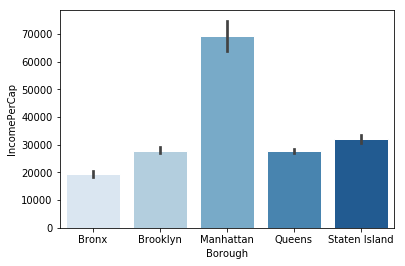

In [110]:
sns.barplot(x = 'Borough', y = 'IncomePerCap', data = newyork_income,
            palette = 'Blues', edgecolor = 'w')




## Based on the plot it can be seen that Manhattan produces the most income by a large margin.

Due to this fact we will eliminate the other 4 Boroughs from contention and the neighborhhods that are in them.

In [128]:
new_df.drop(new_df.loc[new_df['Borough']== 'Queens'].index, inplace=True)

In [129]:
new_df.drop(new_df.loc[new_df['Borough']== 'Staten Island'].index, inplace=True)

In [130]:
new_df.drop(new_df.loc[new_df['Borough']== 'Brooklyn'].index, inplace=True)

In [131]:
new_df.drop(new_df.loc[new_df['Borough']== 'Bronx'].index, inplace=True)

In [132]:
new_df

,Neighborhood,Cluster Labels,Borough,Latitude,Longitude
173,Midtown,1,Manhattan,40.754691,-73.981669
192,Noho,1,Manhattan,40.723259,-73.988434
152,Lincoln Square,1,Manhattan,40.773529,-73.985338
154,Little Italy,1,Manhattan,40.719324,-73.997305
158,Lower East Side,1,Manhattan,40.717807,-73.980890
166,Marble Hill,1,Manhattan,40.876551,-73.910660
272,Tribeca,1,Manhattan,40.721522,-74.010683
283,Washington Heights,1,Manhattan,40.851903,-73.936900
287,West Village,1,Manhattan,40.734434,-74.006180
248,Soho,1,Manhattan,40.722184,-74.000657


The last step will consist of finding the most densely populated parts of Manhattan, to give the restaurant a higher chance of success.

In [133]:
print(new_df.shape)

(32, 5)


In [166]:
df = pd.read_csv('Manhattan_Pop.csv')

In [167]:
df

,Unnamed: 0,Region,Males,Females,Total
0,NaN,"Washington Heights, Inwood & Marble Hill","97,142","106,275","203,417"
1,NaN,"Hamilton Heights, Manhattanville & West Harlem","61,481","68,085","129,566"
2,NaN,Central Harlem,"56,270","65,431","121,701"
3,NaN,East Harlem,"56,312","64,124","120,436"
4,NaN,Upper East Side,"102,121","127,056","229,177"
5,NaN,Upper West Side & West Side,"93,032","108,808","201,840"
6,NaN,"Chelsea, Clinton & Midtown Business District","77,568","71,985","149,553"
7,NaN,"Murray Hill, Gramercy & Stuyvesant Town","71,357","84,491","155,848"
8,NaN,Chinatown & Lower East Side,"81,995","87,276","169,271"
9,NaN,"Battery Park City, Greenwich Village & Soho","75,851","78,330","154,181"


In [169]:
df.sort_values(by=['Total'], inplace=True)

In [170]:
df

,Unnamed: 0,Region,Males,Females,Total
3,NaN,East Harlem,"56,312","64,124","120,436"
2,NaN,Central Harlem,"56,270","65,431","121,701"
1,NaN,"Hamilton Heights, Manhattanville & West Harlem","61,481","68,085","129,566"
6,NaN,"Chelsea, Clinton & Midtown Business District","77,568","71,985","149,553"
9,NaN,"Battery Park City, Greenwich Village & Soho","75,851","78,330","154,181"
7,NaN,"Murray Hill, Gramercy & Stuyvesant Town","71,357","84,491","155,848"
8,NaN,Chinatown & Lower East Side,"81,995","87,276","169,271"
5,NaN,Upper West Side & West Side,"93,032","108,808","201,840"
0,NaN,"Washington Heights, Inwood & Marble Hill","97,142","106,275","203,417"
4,NaN,Upper East Side,"102,121","127,056","229,177"


### Final Observation
Based off sorting the remaining regions and identifying the largest population left in cluster 1,8 or 9, Upper East Side appears to be the best region to expand to

A map of Upper East Side is displayed below

In [180]:
lat = 40.775639
lng = -73.960508

In [186]:
mapy = folium.Map(location=[latitude, longitude], zoom_start=10)
mapy.add_child(
folium.features.CircleMarker(
            [lat, lng],
            radius=8, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='green',
            fill_opacity=0.9
        )
    )